In [23]:
import wbdata
import pandas as pd
import datetime

In [24]:
print(wbdata.get_countries())

id    name
----  --------------------------------------------------------------------------------
ABW   Aruba
AFE   Africa Eastern and Southern
AFG   Afghanistan
AFR   Africa
AFW   Africa Western and Central
AGO   Angola
ALB   Albania
AND   Andorra
ARB   Arab World
ARE   United Arab Emirates
ARG   Argentina
ARM   Armenia
ASM   American Samoa
ATG   Antigua and Barbuda
AUS   Australia
AUT   Austria
AZE   Azerbaijan
BDI   Burundi
BEA   East Asia & Pacific (IBRD-only countries)
BEC   Europe & Central Asia (IBRD-only countries)
BEL   Belgium
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BHI   IBRD countries classified as high income
BHR   Bahrain
BHS   Bahamas, The
BIH   Bosnia and Herzegovina
BLA   Latin America & the Caribbean (IBRD-only countries)
BLR   Belarus
BLZ   Belize
BMN   Middle East, North Africa, Afghanistan & Pakistan (IBRD only)
BMU   Bermuda
BOL   Bolivia
BRA   Brazil
BRB   Barbados
BRN   Brunei Darussalam
BSS   Sub-Saharan Africa (IBRD-only countries)
BTN  

In [25]:
indicators = {
    "NY.GDP.PCAP.CD": "GDP_per_capita",
    "SP.DYN.LE00.IN": "Life_expectancy",
    "FP.CPI.TOTL.ZG": "Inflation",
    "SL.UEM.TOTL.ZS": "Unemployment",
    "SP.POP.TOTL": "Population"
}

data = wbdata.get_dataframe(indicators=indicators, date=('2019', '2019'))
df = data.reset_index()

In [26]:
df.head()

,country,GDP_per_capita,Life_expectancy,Inflation,Unemployment,Population
0,Africa Eastern and Southern,1493.817938,63.857261,4.644967,7.584419,675950189.0
1,Africa Western and Central,1798.340685,57.149847,1.983092,4.395271,463365429.0
2,Arab World,6638.485415,71.839893,1.091848,10.216098,444281315.0
3,Caribbean small states,13938.202320,72.129260,1.000543,8.162114,4443134.0
4,Central Europe and the Baltics,16551.848892,77.265914,2.664561,3.770153,101864274.0


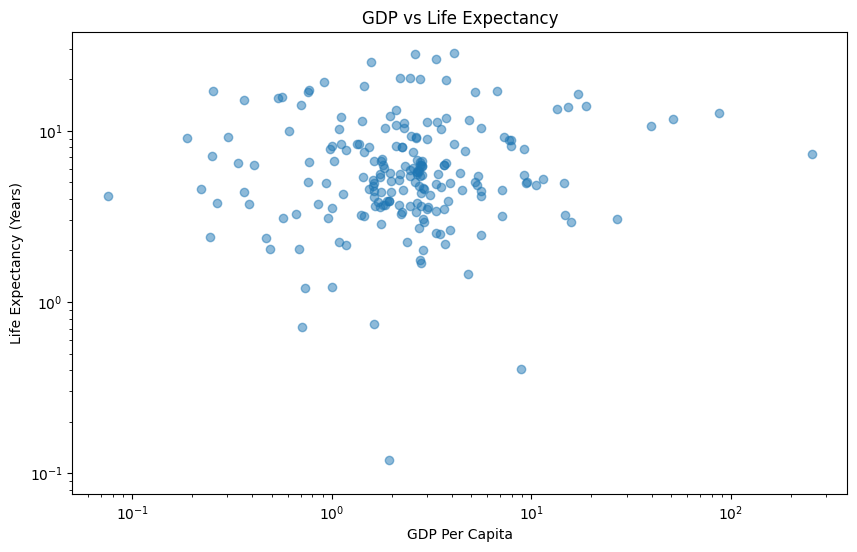

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
plt.scatter(df['Inflation'], df['Unemployment'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('GDP Per Capita')
plt.ylabel('Life Expectancy (Years)')
plt.title('GDP vs Life Expectancy')
plt.show()

In [28]:
knn_df = df[['country', 'Life_expectancy', 'Inflation', 'GDP_per_capita']].dropna()
knn_df

,country,Life_expectancy,Inflation,GDP_per_capita
0,Africa Eastern and Southern,63.857261,4.644967,1493.817938
1,Africa Western and Central,57.149847,1.983092,1798.340685
2,Arab World,71.839893,1.091848,6638.485415
3,Caribbean small states,72.129260,1.000543,13938.202320
4,Central Europe and the Baltics,77.265914,2.664561,16551.848892
...,...,...,...,...
258,Vanuatu,70.783000,2.762520,3207.446505
260,Viet Nam,74.211000,2.795824,3440.900254
262,West Bank and Gaza,75.811000,1.580183,3656.858271
264,Zambia,62.914000,9.150316,1258.986198


In [29]:
import numpy as np

knn_df['Inflation'] = np.clip(knn_df['Inflation'], -20, 50)
knn_df["GDP_per_capita"] = np.clip(knn_df["GDP_per_capita"], 0, 100000)

## Inflation vs Life Expectancy

Taking four clusters for inflation vs life expectancy. Will check a silhouette score and utilise, but depending on plotting outcome may manually find a better metric

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = scaler.fit_transform(knn_df[['Inflation', 'Life_expectancy']])

In [31]:
scores = {}
for k in range(2, 6):
    kmean_checker = KMeans(n_clusters=k, random_state=42)
    labels = kmean_checker.fit_predict(X)
    score = silhouette_score(X, labels)
    scores[k] = score
    print(f'k={k}, silhouette score = {score:.3f}')

best_k = max(scores, key=scores.get)
print(f'Best No. of Clusters: {best_k}')

k=2, silhouette score = 0.495
k=3, silhouette score = 0.506
k=4, silhouette score = 0.403
k=5, silhouette score = 0.449
Best No. of Clusters: 3


In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
knn_df['Cluster'] = kmeans.fit_predict(X)

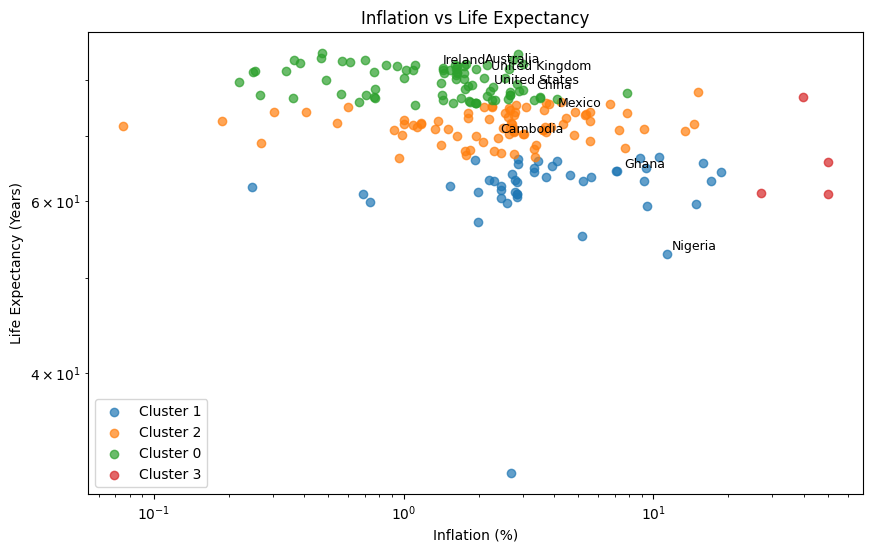

In [33]:
plt.figure(figsize=(10,6))
for cluster in knn_df['Cluster'].unique():
    cluster_data = knn_df[knn_df["Cluster"] == cluster]
    plt.scatter(cluster_data["Inflation"], cluster_data["Life_expectancy"], label=f"Cluster {cluster}", alpha=0.7)

countries = ['United Kingdom', 'Ireland', 'United States', 'China', 'Nigeria', 'Ghana', 'Australia', 'Cambodia', 'Vietnam', 'Mexico']

for _, row in knn_df[knn_df['country'].isin(countries)].iterrows():
    plt.text(row['Inflation']+0.5, row['Life_expectancy']+0.5, row['country'], fontsize=9, color='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Inflation (%)')
plt.ylabel('Life Expectancy (Years)')
plt.title('Inflation vs Life Expectancy')
plt.legend()
plt.show()


In [34]:
print(knn_df.groupby('Cluster')[['Inflation', 'Life_expectancy']].mean())

         Inflation  Life_expectancy
Cluster                            
0         1.537734        79.727291
1         4.382220        61.644352
2         3.078588        71.779760
3        41.718405        66.237500


### Interpretation

Cluster 0 : Implies that with lower Inflation there will be a Higher Life Expectancy.

Cluster 1 & 2 : Imply that with higher inflation rates the life expectancy of a country decreases.

Cluster 3 : Extreme outliers across each cluster. Life expectancy higher as there is an outlier in cluster 2.

## Including GDP

In [35]:
from mpl_toolkits.mplot3d import Axes3D

X_3D = scaler.fit_transform(knn_df[['Inflation', 'Life_expectancy', 'GDP_per_capita']])

kmeans_3D = KMeans(n_clusters=4, random_state=42)

In [36]:
import plotly.express as px

fig = px.scatter_3d(
    knn_df, x='Inflation', y='Life_expectancy', z='GDP_per_capita', color='Cluster', hover_name='country', 
    opacity=0.5
)

fig.update_layout(
    title='Inflation vs Life Expectancy vs GDP Per Capita',
    scene=dict(
        xaxis_title="Inflation (%)",
        yaxis_title="Life Expectancy (years)",
        zaxis_title="GDP per capita (US$)"
    )
)

fig.show()

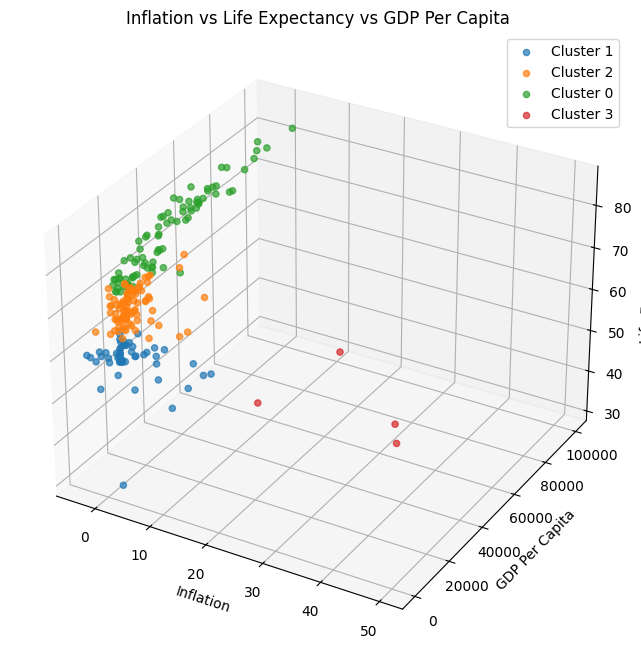

In [37]:
import plotly.express as px

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for cluster in knn_df['Cluster'].unique():
    cluster_data = knn_df[knn_df["Cluster"] == cluster]
    ax.scatter(cluster_data["Inflation"], cluster_data['GDP_per_capita'], cluster_data["Life_expectancy"], label=f"Cluster {cluster}", alpha=0.7)

countries = ['United Kingdom', 'Ireland', 'United States', 'China', 'Nigeria', 'Ghana', 'Australia', 'Cambodia', 'Vietnam', 'Mexico']

#for _, row in knn_df[knn_df['country'].isin(countries)].iterrows():
#    plt.text(row['Inflation']+0.5, row['Life_expectancy']+0.5, row['country'], fontsize=9, color='black')

#plt.xscale('log')
#plt.yscale('log')

ax.set_xlabel('Inflation')
ax.set_ylabel('GDP Per Capita')
ax.set_zlabel('Life Expectancy')
ax.set_title('Inflation vs Life Expectancy vs GDP Per Capita')
ax.legend()
plt.show()